In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry.polygon import LinearRing
from shapely.geometry import box, Polygon
import time
from shapely.geometry import asPoint
import shapely.wkt
import matplotlib.pyplot as plt

In [2]:
def VBOCleaner(data):
    print(data.shape)
    
    # only keep objects with id
    data = data[data["identificatie"].notna()]
    print(data.shape)
    
    # only keep objects which are currently in use # CHECK of dit de juiste zijn
    data = data[data.verblijfsobjectStatus.isin(["Verblijfsobject gevormd", 
                                                 "Verblijfsobject in gebruik",
                                                 "Verblijfsobject in gebruik (niet ingemeten)"])]
    data = data[data.pos.notna()]
    print(data.shape)
    
    data["begindatumTijdvakGeldigheid"] =  pd.to_datetime(data['begindatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    data["einddatumTijdvakGeldigheid"] =  pd.to_datetime(data['einddatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    
    def toPoint(pos):
        return asPoint([float(i) for i in pos.split()[:2]])
    data["pos"] = data.pos.apply(toPoint)
    
    return data

In [3]:
# # Load neccessary datasets
vierkant = gpd.read_file("../Data/NLvierkant/NL_vierkant100m.shp")
df = pd.read_csv("woonplaats_grenzen.csv" , sep = ";")
vbo = pd.read_csv("VBO.csv", sep = ";", encoding = "utf-8", na_values = "NaN", on_bad_lines = "warn")
vbo = VBOCleaner(vbo)

(19501545, 7)
(18918593, 7)
(18386142, 7)


In [4]:
class city_grid():
    def __init__(self, city_borders, grid, city):
        
        # Select only the city_borders of wanted city and transform geometry (string) to geometry object
        self.city_borders = city_borders[city_borders.woonplaats.str.contains(city)]
        self.city_borders.geometry = self.city_borders.geometry.apply(shapely.wkt.loads)
        
        self.grid = grid
        self.city = city
        self.union = LinearRing()
        self.df = gpd.GeoDataFrame()
    
    def border_fix(self, name = "name", loc = "loc"):
        if name != "name":
            self.city_borders =  self.city_borders[~self.city_borders.woonplaats.str.contains(name)]
        elif loc != "loc":
            self.city_borders = self.city_borders.drop(loc)
    
    def print_borders(self):
        print(self.city_borders)
    def create_union(self):
        for _, i in self.city_borders.iterrows():
            if not i.geometry.is_empty:
                x, y = i.geometry.xy
                self.union = self.union.union(i.geometry)
                plt.plot(x, y)
        plt.show()
        
    def create_grid(self):

        def create_box(bounds, distance):
            xmin, ymin, xmax, ymax = bounds
            xmin -= distance
            ymin -= distance
            xmax += distance
            ymax += distance

            return xmin, ymin, xmax, ymax

        boundbox = box(*create_box(self.union.bounds, 100))
        self.bbox = boundbox    
        tot = len(self.grid)
        for i, v in self.grid.iterrows():
            print("{0:.1f}%".format((i / tot) * 100), end = "\r")
            if boundbox.contains(v.geometry):
                self.df = self.df.append(v)
                
    def join_vbo(self, vbo):
        print("joining {} to vbo's".format(self.city))
        vbopoints = gpd.GeoDataFrame(vbo, geometry = "pos")
        grid = self.df
#         grid['geometry'] = grid.geometry.apply(shapely.wkt.loads) # load geometry as shape
        grid = gpd.GeoDataFrame(grid)
        print(grid.shape)
        # join each cbs row with a vbo that contains a vbo point
        self.vbo_grid = gpd.tools.sjoin(vbopoints, grid, op = "within")

        
    def save_grid(self):
        self.df.to_csv("../Data/presnap/grid/" + self.city + "_grid.csv")
        self.vbo_grid.to_csv("../Data/presnap/vbo/" + self.city + "_vbo.csv")

In [ ]:
with open("lists/to_grid.txt", "r+") as f:
    print("hi")
    while True:
        print("hi")
        city = f.readline().strip("\n")
        print(city)
        if city == "":
            break
        else:
            cg = city_grid( df, vierkant, city)
            cg.create_union()
            cg.create_grid()
            cg.join_vbo(vbo)
            cg.save_grid()
            

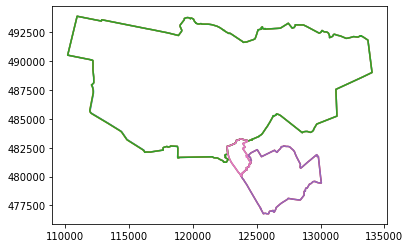

In [9]:
# cg = city_grid( df, vierkant, "Amsterdam")
cg.create_union()


In [8]:
cg.city_borders

,woonplaats,geometry
25,Amsterdam,"LINEARRING (116132.974 482300.26, 116149.018 4..."
26,Amsterdam,"LINEARRING (133164.494 492181.711, 133134.952 ..."
27,Amsterdam,"LINEARRING (133164.494 492181.711, 133134.952 ..."
28,Amsterdam Zuidoost,"LINEARRING (124507.62 481154.734, 124506.85 48..."
29,Amsterdam Zuidoost,"LINEARRING (124507.62 481154.734, 124506.85 48..."
3651,Amsterdam-Duivendrecht,"LINEARRING (123759.017 483272.856, 123736.31 4..."
3652,Amsterdam-Duivendrecht,"LINEARRING (124264.305 481671.198, 124248.461 ..."


In [7]:
cg.border_fix(loc = [1432, 3676])

In [40]:
ams_square = gpd.GeoDataFrame()
for c,i in vierkant.iterrows():
    print("{:.2f}".format(c/len(vierkant)), end = "\r")
    if i.geometry.within(cg.bbox):
        ams_square.loc[:, len(ams_square)] = i


In [42]:
ams_square.shape

(2, 2)

In [ ]:
cg.join_vbo(vbo)

In [19]:
cg.save_grid()

In [11]:
def create_box(bounds, distance):
            xmin, ymin, xmax, ymax = bounds
            xmin -= distance
            ymin -= distance
            xmax += distance
            ymax += distance

            return xmin, ymin, xmax, ymax

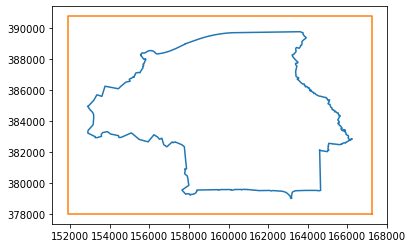

In [13]:
x, y = cg.city_borders.iloc[0].geometry.xy
plt.plot(x, y)
xbox, ybox = box(*create_box(cg.city_borders.iloc[0].geometry.bounds, 1000)).exterior.xy

plt.plot(xbox, ybox)

In [7]:
vbo

,gebruiksdoelVerblijfsobject,oppervlakteVerblijfsobject,verblijfsobjectStatus,begindatumTijdvakGeldigheid,einddatumTijdvakGeldigheid,identificatie,pos
1,woonfunctie,72.0,Verblijfsobject in gebruik,2018-03-26,2018-04-04,1.883100e+15,POINT (188391.884 334586.439)
3,woonfunctie,69.0,Verblijfsobject in gebruik,2010-07-20,NaT,3.100000e+12,POINT (252769.565 593744.87)
4,woonfunctie,69.0,Verblijfsobject in gebruik,2010-07-20,NaT,3.100000e+12,POINT (252890 593697)
5,winkelfunctie,60.0,Verblijfsobject in gebruik,2008-03-20,2014-03-31,3.100000e+12,POINT (252890 593697)
6,winkelfunctie,164.0,Verblijfsobject in gebruik,2014-03-31,2014-05-08,3.100000e+12,POINT (252894.239 593698.471)
...,...,...,...,...,...,...,...
19501536,industriefunctie,1678.0,Verblijfsobject in gebruik (niet ingemeten),2015-10-28,2018-02-08,9.571000e+14,POINT (195783.622 353657.113)
19501538,bijeenkomstfunctie,170.0,Verblijfsobject gevormd,2016-03-23,2018-02-08,9.571000e+14,POINT (198049.808 356330.331)
19501540,bijeenkomstfunctie,230.0,Verblijfsobject gevormd,2016-03-23,2018-02-08,9.571000e+14,POINT (198048.701 356313.161)
19501542,woonfunctie,427.0,Verblijfsobject gevormd,2012-08-22,2018-02-08,9.571000e+14,POINT (200290.765 360276.139)
